In [1053]:
import requests
import pandas as pd

In [1054]:
# https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l59c/mm23

df = pd.read_csv('Full Database.csv')
df

,Url,Sold,Auction Date,Title,Distillery,Region,Strength,Distillery Status,Cask Type,Currency,...,Cask Filling,Previous Spirit,Regauged Date,Age,Bottles At Cask Strength,Buyer Price,Price Per Bottle At Cask Strength,Price Per Litre Of Alcohol,Country,Auction House
0,https://whiskyauctioneer.com/lot/1224-01/cask-...,True,06/01/2025,Port Charlotte 2004 Fresh Bourbon Barrel,Bruichladdich,Islay,50.40,Operational,Barrel,Great Britain Pound (£),...,First Fill,Bourbon,01/10/2024,20.48,212.30,20812.50,87.14,277.87,Scotland,WhiskyAuctioneer
1,https://whiskyauctioneer.com/lot/1124-02a/cask...,False,06/01/2025,Adnams 201Jack Daniel's Barrel,Copper House,England,64.80,Operational,Barrel,Great Britain Pound (£),...,NaN,Bourbon,01/10/2024,13.25,164.86,1125.00,6.07,15.04,England,WhiskyAuctioneer
2,https://whiskyauctioneer.com/lot/1124-01a/cask...,False,06/01/2025,Adnams 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,Great Britain Pound (£),...,NaN,NaN,01/10/2024,9.48,247.97,1125.00,4.03,10.08,England,WhiskyAuctioneer
3,https://whiskyauctioneer.com/lot/1124-01/cask-...,False,02/12/2024,Copper House 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,Great Britain Pound (£),...,NaN,NaN,01/10/2024,9.39,247.97,281.25,1.01,2.52,England,WhiskyAuctioneer
4,https://whiskyauctioneer.com/lot/0824-05a/cask...,True,02/12/2024,Bruichladdich 2002 Climens Hogshead,Bruichladdich,Islay,53.10,Operational,Hogshead,Great Britain Pound (£),...,NaN,Wine,01/06/2024,NaN,310.20,24187.50,69.31,209.78,Scotland,WhiskyAuctioneer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,https://www.thegrandwhiskyauction.com/lot-6621...,False,06/08/2024,Adnams - Single Malt - French Oak Barrique #482,Adnams,England,64.70,Operational,Barrique,Great Britain Pound (£),...,NaN,NaN,NaN,NaN,250.00,2250.00,9.00,19.87,England,The Grand Whisky Auction
349,https://www.thegrandwhiskyauction.com/lot-6621...,True,06/08/2024,Adnams - Single Malt - French Oak Barrique #468,Adnams,England,68.10,Operational,Barrique,Great Britain Pound (£),...,NaN,NaN,NaN,NaN,242.86,2250.00,9.26,19.44,England,The Grand Whisky Auction
350,https://www.thegrandwhiskyauction.com/lot-6100...,True,14/12/2023,Adnams - Single Malt - Jim Beam - 1st Fill Ame...,Adnams,England,66.41,Operational,Barrel,Great Britain Pound (£),...,First Fill,Bourbon,NaN,NaN,149.57,2137.50,14.29,30.74,England,The Grand Whisky Auction
351,https://www.thegrandwhiskyauction.com/lot-6100...,True,14/12/2023,Adnams - Single Malt - Heaven Hill - 1st Fill ...,Adnams,England,70.20,Operational,Barrel,Great Britain Pound (£),...,First Fill,Bourbon,NaN,NaN,113.86,1800.00,15.81,32.17,England,The Grand Whisky Auction


In [1055]:
df['Filling Date'] = pd.to_datetime(df['Filling Date'], format='%d/%m/%Y')

df['Auction Date'] = pd.to_datetime(df['Auction Date'], format='%d/%m/%Y')
df['Year'] = df['Auction Date'].dt.year
df['Month'] = df['Auction Date'].dt.month

df

,Url,Sold,Auction Date,Title,Distillery,Region,Strength,Distillery Status,Cask Type,Currency,...,Regauged Date,Age,Bottles At Cask Strength,Buyer Price,Price Per Bottle At Cask Strength,Price Per Litre Of Alcohol,Country,Auction House,Year,Month
0,https://whiskyauctioneer.com/lot/1224-01/cask-...,True,2025-01-06,Port Charlotte 2004 Fresh Bourbon Barrel,Bruichladdich,Islay,50.40,Operational,Barrel,Great Britain Pound (£),...,01/10/2024,20.48,212.30,20812.50,87.14,277.87,Scotland,WhiskyAuctioneer,2025,1
1,https://whiskyauctioneer.com/lot/1124-02a/cask...,False,2025-01-06,Adnams 201Jack Daniel's Barrel,Copper House,England,64.80,Operational,Barrel,Great Britain Pound (£),...,01/10/2024,13.25,164.86,1125.00,6.07,15.04,England,WhiskyAuctioneer,2025,1
2,https://whiskyauctioneer.com/lot/1124-01a/cask...,False,2025-01-06,Adnams 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,Great Britain Pound (£),...,01/10/2024,9.48,247.97,1125.00,4.03,10.08,England,WhiskyAuctioneer,2025,1
3,https://whiskyauctioneer.com/lot/1124-01/cask-...,False,2024-12-02,Copper House 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,Great Britain Pound (£),...,01/10/2024,9.39,247.97,281.25,1.01,2.52,England,WhiskyAuctioneer,2024,12
4,https://whiskyauctioneer.com/lot/0824-05a/cask...,True,2024-12-02,Bruichladdich 2002 Climens Hogshead,Bruichladdich,Islay,53.10,Operational,Hogshead,Great Britain Pound (£),...,01/06/2024,NaN,310.20,24187.50,69.31,209.78,Scotland,WhiskyAuctioneer,2024,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,https://www.thegrandwhiskyauction.com/lot-6621...,False,2024-08-06,Adnams - Single Malt - French Oak Barrique #482,Adnams,England,64.70,Operational,Barrique,Great Britain Pound (£),...,NaN,NaN,250.00,2250.00,9.00,19.87,England,The Grand Whisky Auction,2024,8
349,https://www.thegrandwhiskyauction.com/lot-6621...,True,2024-08-06,Adnams - Single Malt - French Oak Barrique #468,Adnams,England,68.10,Operational,Barrique,Great Britain Pound (£),...,NaN,NaN,242.86,2250.00,9.26,19.44,England,The Grand Whisky Auction,2024,8
350,https://www.thegrandwhiskyauction.com/lot-6100...,True,2023-12-14,Adnams - Single Malt - Jim Beam - 1st Fill Ame...,Adnams,England,66.41,Operational,Barrel,Great Britain Pound (£),...,NaN,NaN,149.57,2137.50,14.29,30.74,England,The Grand Whisky Auction,2023,12
351,https://www.thegrandwhiskyauction.com/lot-6100...,True,2023-12-14,Adnams - Single Malt - Heaven Hill - 1st Fill ...,Adnams,England,70.20,Operational,Barrel,Great Britain Pound (£),...,NaN,NaN,113.86,1800.00,15.81,32.17,England,The Grand Whisky Auction,2023,12


In [1056]:
df.drop(columns=['Url','Sold','Title','Currency','Filling Date','Regauged Date','Auction House'], inplace=True)
df

,Auction Date,Distillery,Region,Strength,Distillery Status,Cask Type,Bulk Litres,Rla,Cask Filling,Previous Spirit,Age,Bottles At Cask Strength,Buyer Price,Price Per Bottle At Cask Strength,Price Per Litre Of Alcohol,Country,Year,Month
0,2025-01-06,Bruichladdich,Islay,50.40,Operational,Barrel,148.61,74.90,First Fill,Bourbon,20.48,212.30,20812.50,87.14,277.87,Scotland,2025,1
1,2025-01-06,Copper House,England,64.80,Operational,Barrel,115.40,74.78,NaN,Bourbon,13.25,164.86,1125.00,6.07,15.04,England,2025,1
2,2025-01-06,Copper House,England,64.29,Operational,NaN,173.58,111.59,NaN,NaN,9.48,247.97,1125.00,4.03,10.08,England,2025,1
3,2024-12-02,Copper House,England,64.29,Operational,NaN,173.58,111.59,NaN,NaN,9.39,247.97,281.25,1.01,2.52,England,2024,12
4,2024-12-02,Bruichladdich,Islay,53.10,Operational,Hogshead,217.14,115.30,NaN,Wine,NaN,310.20,24187.50,69.31,209.78,Scotland,2024,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,2024-08-06,Adnams,England,64.70,Operational,Barrique,175.00,113.22,NaN,NaN,NaN,250.00,2250.00,9.00,19.87,England,2024,8
349,2024-08-06,Adnams,England,68.10,Operational,Barrique,170.00,115.77,NaN,NaN,NaN,242.86,2250.00,9.26,19.44,England,2024,8
350,2023-12-14,Adnams,England,66.41,Operational,Barrel,104.70,69.53,First Fill,Bourbon,NaN,149.57,2137.50,14.29,30.74,England,2023,12
351,2023-12-14,Adnams,England,70.20,Operational,Barrel,79.70,55.95,First Fill,Bourbon,NaN,113.86,1800.00,15.81,32.17,England,2023,12


In [1057]:
df_inflation_gbp = pd.read_csv('series-110625.csv')
df_inflation_gbp

,Title,CPIH MONTHLY RATE 00: ALL ITEMS 2015=100
0,CDID,L59C
1,Source dataset ID,MM23
2,PreUnit,NaN
3,Unit,%
4,Release date,21-05-2025
...,...,...
510,2024 DEC,0.3
511,2025 JAN,0.0
512,2025 FEB,0.4
513,2025 MAR,0.3


In [1058]:
df_inflation_gbp = df_inflation_gbp.iloc[68:]
df_inflation_gbp

,Title,CPIH MONTHLY RATE 00: ALL ITEMS 2015=100
68,1988 FEB,0.3
69,1988 MAR,0.4
70,1988 APR,1.3
71,1988 MAY,0.5
72,1988 JUN,0.3
...,...,...
510,2024 DEC,0.3
511,2025 JAN,0.0
512,2025 FEB,0.4
513,2025 MAR,0.3


In [1059]:
df_inflation_gbp.columns = ['Date', 'Inflation Rate']

In [1060]:
df_inflation_gbp['Date'] = pd.to_datetime(df_inflation_gbp['Date'])
df_inflation_gbp['Year'] = df_inflation_gbp['Date'].dt.year
df_inflation_gbp['Month'] = df_inflation_gbp['Date'].dt.month
df_inflation_gbp['Inflation Rate'] = round(df_inflation_gbp['Inflation Rate'].astype(float) / 100, 6)
df_inflation_gbp

C:\Users\joaov\AppData\Local\Temp\ipykernel_17716\2859149626.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_inflation_gbp['Date'] = pd.to_datetime(df_inflation_gbp['Date'])
C:\Users\joaov\AppData\Local\Temp\ipykernel_17716\2859149626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inflation_gbp['Date'] = pd.to_datetime(df_inflation_gbp['Date'])
C:\Users\joaov\AppData\Local\Temp\ipykernel_17716\2859149626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,Date,Inflation Rate,Year,Month
68,1988-02-01,0.003,1988,2
69,1988-03-01,0.004,1988,3
70,1988-04-01,0.013,1988,4
71,1988-05-01,0.005,1988,5
72,1988-06-01,0.003,1988,6
...,...,...,...,...
510,2024-12-01,0.003,2024,12
511,2025-01-01,0.000,2025,1
512,2025-02-01,0.004,2025,2
513,2025-03-01,0.003,2025,3


In [1061]:
df_inflation_gbp = df_inflation_gbp[df_inflation_gbp['Date'] >= '2010-01-01'].reset_index(drop=True)
df_inflation_gbp

,Date,Inflation Rate,Year,Month
0,2010-01-01,-0.002,2010,1
1,2010-02-01,0.003,2010,2
2,2010-03-01,0.004,2010,3
3,2010-04-01,0.005,2010,4
4,2010-05-01,0.002,2010,5
...,...,...,...,...
179,2024-12-01,0.003,2024,12
180,2025-01-01,0.000,2025,1
181,2025-02-01,0.004,2025,2
182,2025-03-01,0.003,2025,3


In [1062]:
df_inflation_gbp['Accumulated Inflation'] = (1 + df_inflation_gbp['Inflation Rate'])[::-1].cumprod()[::-1] - 1
df_inflation_gbp['Adjust Value'] = df_inflation_gbp['Accumulated Inflation'] + 1
df_inflation_gbp.drop(columns=['Date','Inflation Rate','Accumulated Inflation'], inplace=True)
df_inflation_gbp

,Year,Month,Adjust Value
0,2010,1,1.548552
1,2010,2,1.551656
2,2010,3,1.547014
3,2010,4,1.540851
4,2010,5,1.533185
...,...,...,...
179,2024,12,1.022153
180,2025,1,1.019096
181,2025,2,1.019096
182,2025,3,1.015036


In [1063]:
df = df.merge(df_inflation_gbp, on=['Year', 'Month'], how='left')
df

,Auction Date,Distillery,Region,Strength,Distillery Status,Cask Type,Bulk Litres,Rla,Cask Filling,Previous Spirit,Age,Bottles At Cask Strength,Buyer Price,Price Per Bottle At Cask Strength,Price Per Litre Of Alcohol,Country,Year,Month,Adjust Value
0,2025-01-06,Bruichladdich,Islay,50.40,Operational,Barrel,148.61,74.90,First Fill,Bourbon,20.48,212.30,20812.50,87.14,277.87,Scotland,2025,1,1.019096
1,2025-01-06,Copper House,England,64.80,Operational,Barrel,115.40,74.78,NaN,Bourbon,13.25,164.86,1125.00,6.07,15.04,England,2025,1,1.019096
2,2025-01-06,Copper House,England,64.29,Operational,NaN,173.58,111.59,NaN,NaN,9.48,247.97,1125.00,4.03,10.08,England,2025,1,1.019096
3,2024-12-02,Copper House,England,64.29,Operational,NaN,173.58,111.59,NaN,NaN,9.39,247.97,281.25,1.01,2.52,England,2024,12,1.022153
4,2024-12-02,Bruichladdich,Islay,53.10,Operational,Hogshead,217.14,115.30,NaN,Wine,NaN,310.20,24187.50,69.31,209.78,Scotland,2024,12,1.022153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,2024-08-06,Adnams,England,64.70,Operational,Barrique,175.00,113.22,NaN,NaN,NaN,250.00,2250.00,9.00,19.87,England,2024,8,1.035499
349,2024-08-06,Adnams,England,68.10,Operational,Barrique,170.00,115.77,NaN,NaN,NaN,242.86,2250.00,9.26,19.44,England,2024,8,1.035499
350,2023-12-14,Adnams,England,66.41,Operational,Barrel,104.70,69.53,First Fill,Bourbon,NaN,149.57,2137.50,14.29,30.74,England,2023,12,1.059513
351,2023-12-14,Adnams,England,70.20,Operational,Barrel,79.70,55.95,First Fill,Bourbon,NaN,113.86,1800.00,15.81,32.17,England,2023,12,1.059513


In [1064]:
df['Adjust Buyer Price'] = round(df['Buyer Price'] * df['Adjust Value'], 2)
df

,Auction Date,Distillery,Region,Strength,Distillery Status,Cask Type,Bulk Litres,Rla,Cask Filling,Previous Spirit,Age,Bottles At Cask Strength,Buyer Price,Price Per Bottle At Cask Strength,Price Per Litre Of Alcohol,Country,Year,Month,Adjust Value,Adjust Buyer Price
0,2025-01-06,Bruichladdich,Islay,50.40,Operational,Barrel,148.61,74.90,First Fill,Bourbon,20.48,212.30,20812.50,87.14,277.87,Scotland,2025,1,1.019096,21209.94
1,2025-01-06,Copper House,England,64.80,Operational,Barrel,115.40,74.78,NaN,Bourbon,13.25,164.86,1125.00,6.07,15.04,England,2025,1,1.019096,1146.48
2,2025-01-06,Copper House,England,64.29,Operational,NaN,173.58,111.59,NaN,NaN,9.48,247.97,1125.00,4.03,10.08,England,2025,1,1.019096,1146.48
3,2024-12-02,Copper House,England,64.29,Operational,NaN,173.58,111.59,NaN,NaN,9.39,247.97,281.25,1.01,2.52,England,2024,12,1.022153,287.48
4,2024-12-02,Bruichladdich,Islay,53.10,Operational,Hogshead,217.14,115.30,NaN,Wine,NaN,310.20,24187.50,69.31,209.78,Scotland,2024,12,1.022153,24723.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,2024-08-06,Adnams,England,64.70,Operational,Barrique,175.00,113.22,NaN,NaN,NaN,250.00,2250.00,9.00,19.87,England,2024,8,1.035499,2329.87
349,2024-08-06,Adnams,England,68.10,Operational,Barrique,170.00,115.77,NaN,NaN,NaN,242.86,2250.00,9.26,19.44,England,2024,8,1.035499,2329.87
350,2023-12-14,Adnams,England,66.41,Operational,Barrel,104.70,69.53,First Fill,Bourbon,NaN,149.57,2137.50,14.29,30.74,England,2023,12,1.059513,2264.71
351,2023-12-14,Adnams,England,70.20,Operational,Barrel,79.70,55.95,First Fill,Bourbon,NaN,113.86,1800.00,15.81,32.17,England,2023,12,1.059513,1907.12


In [1065]:
df.sort_values('Auction Date', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)

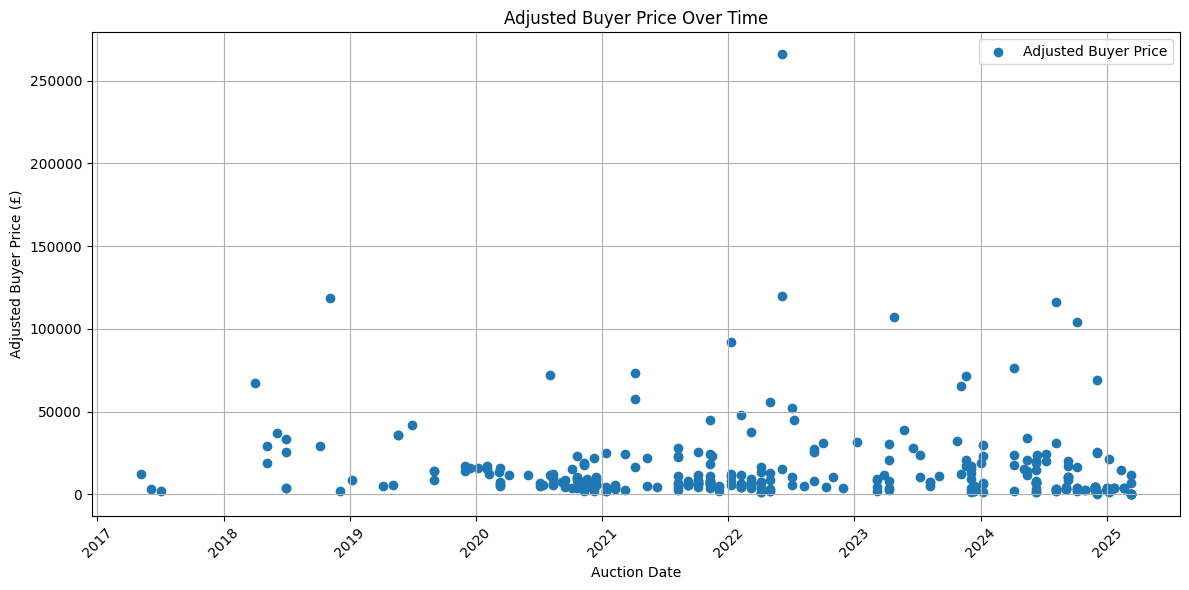

In [1066]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.scatter(df['Auction Date'], df['Adjust Buyer Price'], label='Adjusted Buyer Price', marker='o')
plt.title('Adjusted Buyer Price Over Time')
plt.xlabel('Auction Date')
plt.ylabel('Adjusted Buyer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [1067]:
df.drop(columns=['Buyer Price', 'Adjust Value', 'Year', 'Month', 'Auction Date', 'Cask Type','Cask Filling','Previous Spirit'], inplace=True)
df

,Distillery,Region,Strength,Distillery Status,Bulk Litres,Rla,Age,Bottles At Cask Strength,Price Per Bottle At Cask Strength,Price Per Litre Of Alcohol,Country,Adjust Buyer Price
0,Lochranza,Islands,57.30,Operational,202.70,116.15,NaN,289.57,21.07,59.08,Scotland,6965.68
1,Copper House,England,68.06,Operational,135.22,92.03,8.57,193.17,1.81,4.28,England,399.67
2,Copper House,England,65.32,Operational,168.86,110.30,8.57,241.23,1.45,3.57,England,399.67
3,Dublin Liberties Distillery,Ireland,62.20,Operational,154.85,96.32,NaN,221.21,1.58,4.09,Ireland,399.67
4,Dublin Liberties Distillery,Ireland,59.01,Operational,177.77,104.90,NaN,253.96,1.38,3.75,Ireland,399.67
...,...,...,...,...,...,...,...,...,...,...,...,...
348,Ben Nevis,Highlands,57.20,Operational,398.65,230.76,21.44,569.50,35.12,97.50,Scotland,29410.88
349,Ben Nevis,Highlands,57.20,Operational,398.65,230.76,21.34,569.50,79.82,221.63,Scotland,67118.34
350,Ardmore,Highlands,NaN,Operational,NaN,NaN,7.50,NaN,NaN,NaN,Scotland,2250.26
351,Linkwood,Speyside,NaN,Operational,NaN,NaN,7.43,NaN,NaN,NaN,Scotland,3300.38


In [1068]:
df.drop(columns=['Price Per Bottle At Cask Strength', 'Price Per Litre Of Alcohol'], inplace=True)
df

,Distillery,Region,Strength,Distillery Status,Bulk Litres,Rla,Age,Bottles At Cask Strength,Country,Adjust Buyer Price
0,Lochranza,Islands,57.30,Operational,202.70,116.15,NaN,289.57,Scotland,6965.68
1,Copper House,England,68.06,Operational,135.22,92.03,8.57,193.17,England,399.67
2,Copper House,England,65.32,Operational,168.86,110.30,8.57,241.23,England,399.67
3,Dublin Liberties Distillery,Ireland,62.20,Operational,154.85,96.32,NaN,221.21,Ireland,399.67
4,Dublin Liberties Distillery,Ireland,59.01,Operational,177.77,104.90,NaN,253.96,Ireland,399.67
...,...,...,...,...,...,...,...,...,...,...
348,Ben Nevis,Highlands,57.20,Operational,398.65,230.76,21.44,569.50,Scotland,29410.88
349,Ben Nevis,Highlands,57.20,Operational,398.65,230.76,21.34,569.50,Scotland,67118.34
350,Ardmore,Highlands,NaN,Operational,NaN,NaN,7.50,NaN,Scotland,2250.26
351,Linkwood,Speyside,NaN,Operational,NaN,NaN,7.43,NaN,Scotland,3300.38


In [1069]:
df.isnull().sum()

Distillery                   3
Region                       1
Strength                     5
Distillery Status            1
Bulk Litres                  7
Rla                          9
Age                         94
Bottles At Cask Strength     7
Country                      2
Adjust Buyer Price           0
dtype: int64

In [1070]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

Distillery                  0
Region                      0
Strength                    0
Distillery Status           0
Bulk Litres                 0
Rla                         0
Age                         0
Bottles At Cask Strength    0
Country                     0
Adjust Buyer Price          0
dtype: int64

In [1071]:
df = pd.get_dummies(df, columns=['Distillery','Region','Distillery Status','Country'], drop_first=True, dtype=int)
df

,Strength,Bulk Litres,Rla,Age,Bottles At Cask Strength,Adjust Buyer Price,Distillery_Allt-A-Bhainne,Distillery_Ardbeg,Distillery_Ardmore,Distillery_Arran (Lochranza),...,Region_Lowlands,Region_Speyside,Region_Trinidad,Region_USA,Distillery Status_Operational,Country_Hogshead,Country_Ireland,Country_Scotland,Country_Trinidad,Country_USA
0,68.06,135.22,92.03,8.57,193.17,399.67,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,65.32,168.86,110.30,8.57,241.23,399.67,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,64.80,115.40,74.78,13.25,164.86,1146.48,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,50.40,148.61,74.90,20.48,212.30,21209.94,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,64.29,173.58,111.59,9.48,247.97,1146.48,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,59.90,201.00,120.40,10.32,287.14,3811.98,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
245,49.26,118.00,58.13,37.32,168.57,37386.71,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
246,64.10,201.00,128.84,14.35,287.14,18896.49,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
247,57.20,398.65,230.76,21.44,569.50,29410.88,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [1072]:
from sklearn.model_selection import train_test_split

x = df.drop(columns=['Adjust Buyer Price'])
y = df['Adjust Buyer Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((199, 81), (50, 81), (199,), (50,))

In [1073]:
from sklearn.preprocessing import StandardScaler

scaler_x_train = StandardScaler()
x_train[['Strength', 'Bulk Litres', 'Rla', 'Age', 'Bottles At Cask Strength']] = scaler_x_train.fit_transform(x_train[['Strength', 'Bulk Litres', 'Rla', 'Age', 'Bottles At Cask Strength']])

scaler_x_test = StandardScaler()
x_test[['Strength', 'Bulk Litres', 'Rla', 'Age', 'Bottles At Cask Strength']] = scaler_x_test.fit_transform(x_test[['Strength', 'Bulk Litres', 'Rla', 'Age', 'Bottles At Cask Strength']])

# ML Models

In [1074]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [1075]:
models_metrics = {}

## Linear Regression

In [1076]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Linear Regression'] = {'RMSE': rmse}

pred_vs_test

RMSE: 12383.77
R^2: 0.67


,Actual,Predicted,Error
0,6214.55,5590.018624,624.53
1,25873.26,20000.793596,5872.47
2,1465.60,4190.995469,-2725.40
3,10791.84,1566.157185,9225.68
4,6498.06,11103.216356,-4605.16
5,9230.80,784.864336,8445.94
6,5254.46,9563.068403,-4308.61
7,4615.40,-1451.720443,6067.12
8,2028.49,44280.143193,-42251.65
9,5915.15,8734.096610,-2818.95


## Random Forest

In [1078]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
101 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best RMSE: -17754.32
Best estimator: RandomForestRegressor(max_features='log2', min_samples_split=5, random_state=1)


In [1079]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Random Forest'] = {'RMSE': rmse}

pred_vs_test

RMSE: 12565.01


,Actual,Predicted,Error
0,6214.55,6833.625819,-619.08
1,25873.26,39473.932170,-13600.67
2,1465.60,5387.406131,-3921.81
3,10791.84,8346.995750,2444.84
4,6498.06,7130.118695,-632.06
5,9230.80,7503.161671,1727.64
6,5254.46,7402.235443,-2147.78
7,4615.40,5936.871039,-1321.47
8,2028.49,19917.687660,-17889.20
9,5915.15,8949.830958,-3034.68


## SVM

In [1080]:
from sklearn.svm import SVR

model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
Best RMSE: -24967.55
Best estimator: SVR(C=10, kernel='linear')


In [1081]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['SVM'] = {'RMSE': rmse}

pred_vs_test

RMSE: 21411.65


,Actual,Predicted,Error
0,6214.55,7118.307452,-903.76
1,25873.26,12861.008518,13012.25
2,1465.60,7469.684894,-6004.08
3,10791.84,8484.656446,2307.18
4,6498.06,8765.448453,-2267.39
5,9230.80,8165.511639,1065.29
6,5254.46,7546.935502,-2292.48
7,4615.40,8384.738108,-3769.34
8,2028.49,8857.814390,-6829.32
9,5915.15,8214.910902,-2299.76


## Gradient Boosting

In [1082]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best RMSE: -16340.30
Best estimator: GradientBoostingRegressor(max_depth=5, min_samples_split=5, n_estimators=50,
                          random_state=1)


In [1083]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics['Gradient Boost'] = {'RMSE': rmse}

pred_vs_test

RMSE: 13992.31


,Actual,Predicted,Error
0,6214.55,8004.238890,-1789.69
1,25873.26,30336.843696,-4463.58
2,1465.60,5146.251155,-3680.65
3,10791.84,8223.847230,2567.99
4,6498.06,8223.847230,-1725.79
5,9230.80,6736.797324,2494.00
6,5254.46,5285.223960,-30.76
7,4615.40,6736.797324,-2121.40
8,2028.49,18581.559843,-16553.07
9,5915.15,8163.456442,-2248.31


## Metrics

In [1084]:
models_metrics = pd.DataFrame(models_metrics).T
models_metrics['RMSE'] = models_metrics['RMSE'].round(2)
models_metrics

,RMSE,R^2
Linear Regression,12383.77,0.672313
Random Forest,12565.01,NaN
SVM,21411.65,NaN
Gradient Boost,13992.31,NaN
